# Dependências

In [234]:
import numpy as np
import matplotlib.pyplot as plt

# Configurações

In [235]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 15

# Utils

In [236]:
voc = ["EU", "VOCÊ", "É", "SOU", "MUITO", "LEGAL", "DEMAIS", "INCRÍVEL"]

def encode(text):
  a_text = text.split(" ")
  r = []
  for i in a_text:
    if i in voc:
      r.append(voc.index(i))
  return np.array(r)

def probs(word):
  r = np.zeros(len(voc))
  i = voc.index(word)

  if i > -1:
    r[i] = 1.0

  return r

def decode(a_text):
  return voc[np.argmax(a_text)]

# Dataset

In [237]:
# inputs = np.array([
#     [0, 0, 0],
#     [0, 0, 1],
#     [0, 1, 0],
#     [0, 1, 1],
#     [1, 0, 0]
#     ])

inputs = np.array([
    encode("EU SOU MUITO"),
    encode("MUITO LEGAL EU"),
    encode("EU SOU LEGAL"),
    encode("VOCÊ É MUITO"),
    encode("VOCÊ É LEGAL")
    ])

targets = np.array([
    probs("LEGAL"),
    probs("SOU"),
    probs("DEMAIS"),
    probs("LEGAL"),
    probs("DEMAIS")
    ])

# targets = np.array([
#     [0.0],
#     [0.1],
#     [0.2],
#     [0.3],
#     [0.4]
#     ])

print(f"Inputs: \n{inputs}")
print(f"Targets: \n{targets}")

Inputs: 
[[0 3 4]
 [4 5 0]
 [0 3 5]
 [1 2 4]
 [1 2 5]]
Targets: 
[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


# Arquitetura

In [238]:
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Inicialização dos pesos e biases
        self.weights_input_hidden = np.random.uniform(size=(input_size, hidden_size))
        self.weights_hidden_hidden = np.random.uniform(size=(hidden_size, hidden_size))
        self.biases_hidden = np.zeros(hidden_size)

        self.weights_hidden_output = np.random.uniform(size=(hidden_size, output_size))
        self.biases_output = np.zeros(output_size)

        # Estado oculto
        self.hidden_state = np.zeros(hidden_size)

    # def sigmoid(self, x):
    #     return 1 / (1 + np.exp(-x))

    # def sigmoid_derivative(self, x):
    #     return x * (1 - x)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1.0 - np.tanh(x)**2

    def softmax(self, x):
      exp_x = np.exp(x)
      sum_exp_x = np.sum(exp_x, axis=-1, keepdims=True)
      return exp_x / sum_exp_x


    def train(self, inputs, targets, epochs, learning_rate):
        loss_history = []

        for epoch in range(epochs):
            total_loss = 0

            for i in range(len(inputs)):
                # Forward pass
                input_layer = inputs[i]
                hidden_layer_input = np.dot(input_layer, self.weights_input_hidden) + np.dot(self.hidden_state, self.weights_hidden_hidden) + self.biases_hidden
                hidden_layer_output = self.tanh(hidden_layer_input)
                #hidden_layer_output = self.sigmoid(hidden_layer_input)


                output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_output) + self.biases_output
                predicted_output = self.softmax(output_layer_input)

                # Calcula o erro
                error = targets[i] - predicted_output
                total_loss += np.sum(error ** 2)

                # Backpropagation
                output_delta = error
                hidden_delta = output_delta.dot(self.weights_hidden_output.T) * self.tanh_derivative(hidden_layer_output)
                #hidden_delta = output_delta.dot(self.weights_hidden_output.T) * self.sigmoid_derivative(hidden_layer_output)


                # Atualiza os pesos e biases
                self.weights_hidden_output += hidden_layer_output.reshape(-1, 1) * output_delta * learning_rate
                self.biases_output += output_delta * learning_rate

                self.weights_input_hidden += input_layer.reshape(-1, 1) * hidden_delta * learning_rate
                self.weights_hidden_hidden += np.outer(self.hidden_state, hidden_delta) * learning_rate
                self.biases_hidden += hidden_delta * learning_rate

                # Atualiza o estado oculto
                self.hidden_state = hidden_layer_output

            # Calcula o erro médio quadrático médio para a época
            avg_loss = total_loss / len(inputs)
            loss_history.append(avg_loss)

            # Exibe o erro médio quadrático a cada época
            print(f"Época {epoch + 1}/{epochs}, Erro Médio Quadrático: {avg_loss}")

        return loss_history

    def predict(self, initial_sequence):
        current_input = np.array(initial_sequence)
        hidden_layer_input = np.dot(current_input, self.weights_input_hidden) + np.dot(self.hidden_state, self.weights_hidden_hidden) + self.biases_hidden
        hidden_layer_output = self.tanh(hidden_layer_input)
        #hidden_layer_output = self.sigmoid(hidden_layer_input)

        output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_output) + self.biases_output
        predicted_output = output_layer_input

        # Atualiza o estado oculto
        self.hidden_state = hidden_layer_output

        return self.softmax(predicted_output)

# Treinamento

In [239]:
# Hiperparâmetros
epochs = 8000
learning_rate = 0.001

# Cria e treina a RRN
rnn = SimpleRNN(input_size=len(inputs[0]), hidden_size=10, output_size=len(targets[0]))
losses = rnn.train(inputs, targets, epochs, learning_rate)


Streaming output truncated to the last 5000 lines.
Época 3001/8000, Erro Médio Quadrático: 0.40953969217707675
Época 3002/8000, Erro Médio Quadrático: 0.40953385026853795
Época 3003/8000, Erro Médio Quadrático: 0.4095280145211161
Época 3004/8000, Erro Médio Quadrático: 0.4095221849250743
Época 3005/8000, Erro Médio Quadrático: 0.4095163614706946
Época 3006/8000, Erro Médio Quadrático: 0.40951054414827154
Época 3007/8000, Erro Médio Quadrático: 0.4095047329481155
Época 3008/8000, Erro Médio Quadrático: 0.40949892786055264
Época 3009/8000, Erro Médio Quadrático: 0.40949312887592304
Época 3010/8000, Erro Médio Quadrático: 0.4094873359845841
Época 3011/8000, Erro Médio Quadrático: 0.4094815491769054
Época 3012/8000, Erro Médio Quadrático: 0.4094757684432732
Época 3013/8000, Erro Médio Quadrático: 0.4094699937740883
Época 3014/8000, Erro Médio Quadrático: 0.4094642251597656
Época 3015/8000, Erro Médio Quadrático: 0.40945846259073715
Época 3016/8000, Erro Médio Quadrático: 0.4094527060574474

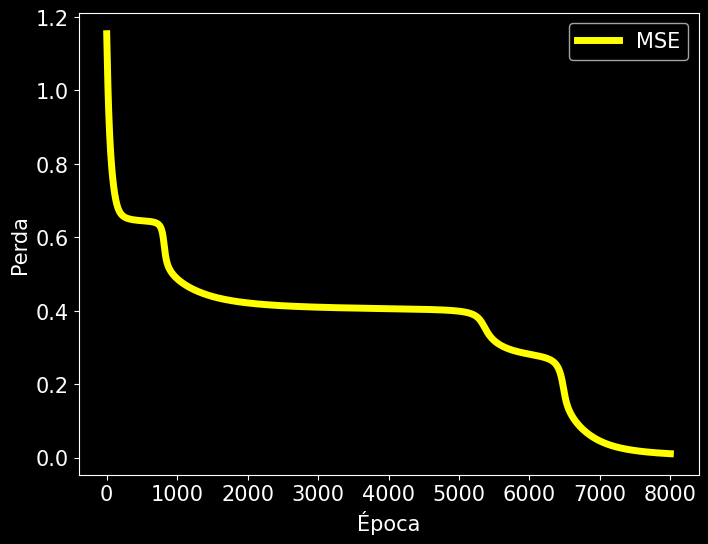

In [240]:
data_epochs = np.arange(0, epochs, 1)

plt.plot(data_epochs, losses, color="yellow", lw=5, label = 'MSE')

plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Teste

In [241]:
# Testa a previsão com uma nova sequência
#test_sequence = [1, 0, 1]

text = "EU SOU MUITO" #Valor conhecido
# text = "VOCÊ É INCRÍVEL" #valor desconhecido
# text = "SOU MUITO INCRÍVEL" #valor desconhecido meio provável
# text = "VOCÊ É EU" #valor desconhecido improvável
# text = "EU SOU É" #valor desconhecido improvável

test_sequence = encode(text)
predicted_output = rnn.predict(test_sequence)

print(f"Vocabulário: {voc}")
print()
print(f"Frases conhecidas:\n")

for i in range(len(inputs)):
    s = ""
    for j in inputs[i]:
      s += voc[j] +" "
    print(f"{s}{decode(targets[i])}")

print()

print(f"Sequência de entrada: {test_sequence}")
print(f"Sequência prevista: {predicted_output}")
print()

print(f"Texto de entrada: {text} ...")
print(f"Texto de saída: {text} {decode(predicted_output)}. ({np.max(predicted_output)})")


Vocabulário: ['EU', 'VOCÊ', 'É', 'SOU', 'MUITO', 'LEGAL', 'DEMAIS', 'INCRÍVEL']

Frases conhecidas:

EU SOU MUITO LEGAL
MUITO LEGAL EU SOU
EU SOU LEGAL DEMAIS
VOCÊ É MUITO LEGAL
VOCÊ É LEGAL DEMAIS

Sequência de entrada: [0 3 4]
Sequência prevista: [2.87612131e-04 3.60872660e-04 3.22336453e-04 9.62652779e-03
 4.48647755e-04 9.23184816e-01 6.53419895e-02 4.27197977e-04]

Texto de entrada: EU SOU MUITO ...
Texto de saída: EU SOU MUITO LEGAL. (0.9231848157474232)
